# **NLP Project 2 : Supervised Learning**
## Léo RINGEISSEN and Santiago MARTIN

# Library Importations

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Data Import and Aggregation
## Description:
This section imports all Excel files, combines them into a single DataFrame, and selects relevant columns for further processing.
### Justification:
Aggregating all files upfront ensures consistent preprocessing. We select relevant columns (`rating`, `product`, `type`, and `review`) for the supervised learning task.

In [1]:
# Step 1: Gather all Excel file paths
file_paths = glob.glob("Traduction avis clients/*.xlsx")

# Step 2: Load and combine files
dataframes = []
for file in file_paths:
    df = pd.read_excel(file)
    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Select relevant columns
selected_columns = ["note", "produit", "type", "avis_en"]  # French column names
combined_df = combined_df[selected_columns]

# Rename columns to English
combined_df.columns = ["rating", "product", "type", "review"]

# Manual Translation of `product` Column
## Description:
Manually translate the values in the `product` column to English using predefined mappings.
### Justification:
Standardizing product names ensures uniformity and facilitates downstream analysis.

In [2]:
# Correct product translations
product_translations = {
    "animaux": "animals",
    "auto": "car",
    "credit": "credit",
    "garantie-decennale": "ten-year warranty",
    "habitation": "home",
    "moto": "motorcycle",
    "multirisque-professionnelle": "professional multi-risk",
    "prevoyance": "accidental injury",
    "responsabilite-civile-professionnelle": "professional liability",
    "sante": "health",
    "vie": "life"
}

# Apply translations to `product` column
combined_df["product"] = combined_df["product"].map(product_translations)

# Clean English Reviews
## Description:
Process the `review` column to:
1. Remove faulty reviews containing "Loading...".
2. Ensure reviews are stripped of extra spaces and line breaks, leaving clean single-line reviews.
### Justification:
Removing faulty reviews and standardizing formatting enhances data quality and improves model performance.

In [3]:
# Remove faulty reviews and clean the text
combined_df["review"] = (
    combined_df["review"]
    .str.replace(r"\s+", " ", regex=True)  # Replace extra spaces and newlines with a single space
    .str.strip()  # Remove leading/trailing spaces
)

# Filter out rows with "Loading..."
combined_df = combined_df[~combined_df["review"].str.contains("Loading...", na=False)]

# Removing null values (focus on ratings)
## Description:
We're going to remove rows with null values
1. The data of type `test` don't have ratings, which problematic for a supervised learning task
2. There are also other columns with null values, which can't be exploited
### Justification:
Removing faulty rows enhances data quality and improves model performance.

In [4]:
print(combined_df.isnull().sum())
combined_df.dropna(inplace=True)
print(combined_df.isnull().sum())

rating     9782
product      16
type          0
review        2
dtype: int64
rating     0
product    0
type       0
review     0
dtype: int64


# Summary of Cleaned Data
## Description:
Display a summary of the cleaned dataset, including:
1. The total number of rows and columns.
2. A count of unique products, ratings, and ratings-product combos, along with their their distribution.
3. The first few rows to verify correctness.
### Justification:
This step ensures the preprocessing pipeline has produced a clean and structured dataset.

In [5]:
print("Total rows and columns:", combined_df.shape)

Total rows and columns: (23539, 4)


In [6]:
print("\nUnique ratings and counts:")
print(combined_df["rating"].value_counts())

sns.countplot(x="rating", data=combined_df)
plt.title("Distribution of Ratings")
plt.show()


Unique ratings and counts:
rating
1.0    7094
4.0    4771
5.0    4745
2.0    3635
3.0    3294
Name: count, dtype: int64


In [7]:
print("\nUnique product categories and counts:")
print(combined_df["product"].value_counts())

sns.countplot(x="product", data=combined_df)
plt.title("Distribution of Products")
plt.show()


Unique product categories and counts:
product
car                        13745
health                      3443
motorcycle                  2063
home                        1922
accidental injury            768
credit                       640
life                         559
animals                      364
professional multi-risk       19
ten-year warranty             11
professional liability         5
Name: count, dtype: int64



Count of products per rating:
rating  product                
1.0     car                        2948
        health                     1381
        home                       1054
        accidental injury           506
        life                        395
        motorcycle                  309
        credit                      265
        animals                     214
        ten-year warranty             9
        professional multi-risk       8
        professional liability        5
2.0     car                        2049
        home                        526
        health                      431
        motorcycle                  264
        accidental injury           115
        credit                       95
        life                         84
        animals                      70
        professional multi-risk       1
3.0     car                        2096
        health                      522
        motorcycle                  263
        home     

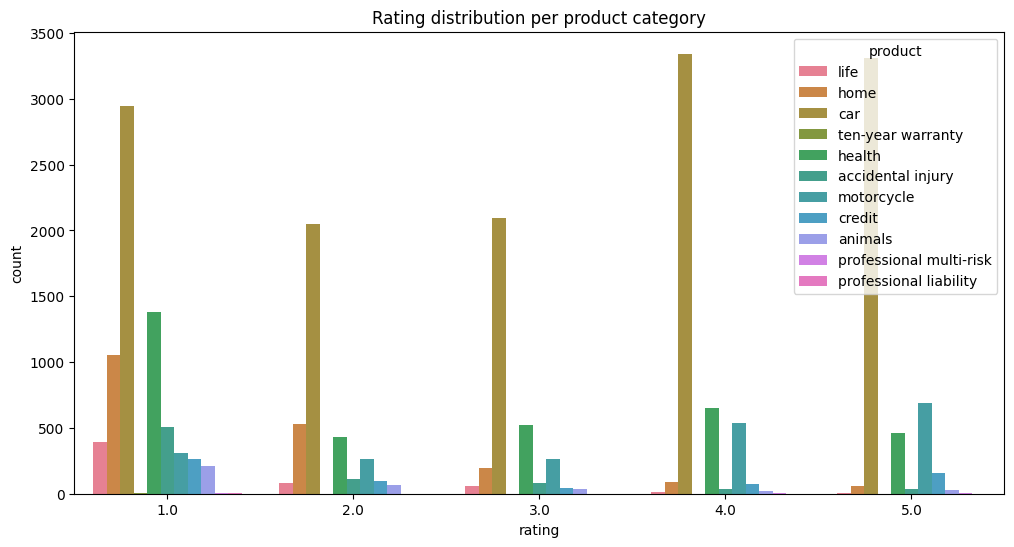

In [15]:
print("\nCount of products per rating:")
print(combined_df.groupby("rating")["product"].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x="rating", hue="product")
plt.title("Rating distribution per product category")
plt.show()

In [8]:
print("\nSample data:")
display(combined_df.head())


Sample data:


,rating,product,type,review
0,4.0,car,train,The person on the phone was clear and friendly...
1,4.0,motorcycle,train,"Satisfied. Reactivity, simplicity. Attractive ..."
2,1.0,life,train,"Insurer to flee, does not ensure its responsib..."
3,1.0,home,train,The GMF has been waiting for a water damage fo...
4,3.0,car,train,I am good with this insurance. She is practica...


In [9]:
combined_df.to_csv("combined_reviews.csv", index=False)

# Exploratory Data Analysis and Word Frequency
In this section, we'll analyze the cleaned text reviews to highlight frequent words and n-grams. This helps us understand the data distribution and potential features for model building.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate n-grams
def plot_ngrams(reviews, n=1, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(reviews)
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_words = vectorizer.get_feature_names_out()
    ngram_data = sorted(zip(ngram_freq, ngram_words), reverse=True)[:top_n]
    
    plt.barh([x[1] for x in ngram_data], [x[0] for x in ngram_data])
    plt.xlabel("Frequency")
    plt.title(f"Top {n}-grams")
    plt.show()

# Plot frequent words and bigrams
plot_ngrams(df['review'], n=1)  # Unigrams
plot_ngrams(df['review'], n=2)  # Bigrams

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(df['review']))

ModuleNotFoundError: No module named 'wordcloud'